In [1]:
import cPickle as pickle
from matplotlib import pyplot as plt
import os
import numpy as np

# Grab Input Data
labels_file = '../image_dump/train_test_list.txt'
data_files_path = '../../VOC2012/fc7_features/'

data = []
labels = []
data_files = []
with open(labels_file) as f:
    for line in f:
        data_file, label = line.split(' ')
        data_file = data_file.split('/')[-1].split('.')[0] + '.pi'
        try:
            data.append(pickle.load(open(data_files_path + data_file, 'rb')))
            labels.append(int(label))
            data_files.append(data_file)
        except IOError as e:
            pass
data = np.squeeze(np.array(data))
labels = np.array(labels)
data_files = np.array(data_files)
print data.shape, labels.shape, data_files.shape

(36304, 4096) (36304,) (36304,)


In [122]:
data_whole = data
labels_whole = labels
data_files_whole = data_files

# Remove Background labels
data = data_whole[labels_whole != 0]
labels = labels_whole[labels_whole != 0]
data_files = data_files_whole[labels_whole != 0]
print data.shape, labels.shape, data_files.shape

(22216, 4096) (22216,) (22216,)


In [123]:
# Split data into training and test
num_vectors = data.shape[0]
test_ratio = .2
num_test = num_vectors * test_ratio

indices = np.random.permutation(num_vectors)
training_idx, test_idx = indices[num_test:], indices[:num_test]
training_data, test_data = data[training_idx,:], data[test_idx,:]
training_labels, test_labels = labels[training_idx,], labels[test_idx,]

print training_data.shape, test_data.shape
print training_labels.shape, test_labels.shape

(17773, 4096) (4443, 4096)
(17773,) (4443,)


In [131]:
# Define Classifier
# http://scikit-learn.org/stable/modules/grid_search.html
from sklearn import svm, neighbors, linear_model, ensemble, grid_search 

scoring = 'f1_weighted'
class_weight = 'auto' # 'subsample' (forests only), 'auto'

classifier = ensemble.RandomForestClassifier(n_estimators=20, max_depth=15, class_weight=class_weight)
# classifier = grid_search.GridSearchCV(svm.LinearSVC(class_weight=class_weight), {'C':[.01, .1, 1, 10, 100]}, scoring=scoring)

# classifier = linear_model.RidgeClassifierCV()
# classifier = linear_model.SGDClassifier()
# classifier = ensemble.AdaBoostClassifier()
# classifer = ensemble.GradientBoostingClassifier()
# classifer = ensemble.ExtraTreesClassifier()

## Slow
# classifier = grid_search.GridSearchCV(svm.SVC(class_weight=class_weight), {'kernel':('linear','rbf'), 'C':[.01, .1, 1, 10, 100]}, scoring=scoring)
# classifier = neighbors.KNeighborsClassifier()

In [132]:
%%time
# Train Classifier
classifier.fit(training_data, training_labels);

CPU times: user 8.81 s, sys: 440 ms, total: 9.25 s
Wall time: 9.4 s


RandomForestClassifier(bootstrap=True, class_weight='auto', criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [133]:
# Test Classifier
from sklearn.cross_validation import cross_val_score

predicted_labels = classifier.predict(test_data)
print classifier.score(training_data, training_labels) # score is always accuracy
print cross_val_score(classifier, training_data, training_labels, scoring=scoring)
print classifier.score(test_data, test_labels) # score is always accuracy

0.997805660271
[ 0.94335252  0.93992703  0.94743916]
0.949358541526


In [134]:
import pandas
from sklearn.metrics import confusion_matrix
wrong_test_idx = np.arange(test_labels.shape[0])[predicted_labels != test_labels]
wrong_data_files_idx = test_idx[wrong_test_idx]
wrong_data_files = data_files[wrong_data_files_idx]

wrong_predicted = predicted_labels[predicted_labels != test_labels]
wrong_true = test_labels[predicted_labels != test_labels]

# Labels 0-5 = background, person, bike, bus, car, motorbike
print "Training Confusion Matrix"
print confusion_matrix(training_labels, classifier.predict(training_data))
print "Test Results"
print "Wrong:", len(wrong_true), '/', len(test_labels), ',', float(len(wrong_true))/len(test_labels)
print confusion_matrix(test_labels, predicted_labels)
print pandas.DataFrame({"Image Index": wrong_data_files, "Predicted": wrong_predicted, "Truth": wrong_true})

Training Confusion Matrix
[[13920     2     0     8    11]
 [    3   682     0     0     0]
 [    0     0   535     3     0]
 [    9     0     0  1977     0]
 [    3     0     0     0   620]]
Test Results
Wrong: 225 / 4443 , 0.050641458474
[[3438    2    0   13    7]
 [  31  108    0    8    5]
 [   8    0  118   21    0]
 [  63    0    6  433    4]
 [  43    6    0    8  121]]
       Image Index  Predicted  Truth
0     pict_2549.pi          4      1
1    pict_14983.pi          1      4
2     pict_7539.pi          1      2
3    pict_14403.pi          1      2
4     pict_4595.pi          3      4
5     pict_3144.pi          4      2
6     pict_6817.pi          1      4
7     pict_9465.pi          5      4
8    pict_14434.pi          1      4
9    pict_11504.pi          1      4
10   pict_16124.pi          1      4
11    pict_3125.pi          1      5
12     pict_896.pi          1      5
13   pict_15808.pi          5      2
14   pict_20450.pi          4      1
15   pict_10115.pi         

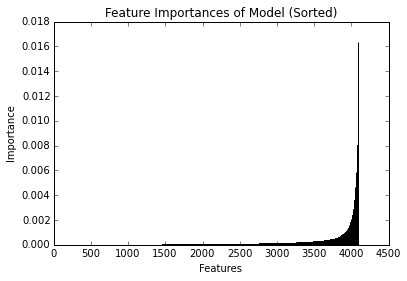

In [136]:
%matplotlib inline
# Visualize Feature Importances
# Forest/Tree Classifiers only
import matplotlib.pyplot as plt

importances = classifier.feature_importances_

width = 0.35       # the width of the bars
# plt.subplot(211)
# plt.bar(np.arange(importances.shape[0]), importances, width, color='r')
plt.title("Feature Importances of Model (Sorted)")
# plt.ylabel("Importance")
# plt.subplot(212)
plt.bar(np.arange(importances.shape[0]),sorted(importances), width, color='r')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

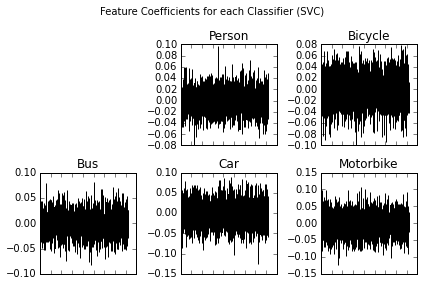

In [130]:
%matplotlib inline
# Visualize Feature Coefficients for each Class
# SVC Classifier
import matplotlib.pyplot as plt

importances = classifier.best_estimator_.coef_

width = 0.35       # the width of the bars

fig = plt.figure()
# ax = fig.add_subplot(231)
# ax.set_xticklabels([])
# plt.bar(np.arange(importances.shape[1]), importances[0,:], width)
# plt.title("Background")
ax = fig.add_subplot(232)
ax.set_xticklabels([])
plt.bar(np.arange(importances.shape[1]), importances[0,:], width)
plt.title("Person")
ax = fig.add_subplot(233)
ax.set_xticklabels([])
plt.bar(np.arange(importances.shape[1]), importances[1,:], width)
plt.title("Bicycle")
ax = fig.add_subplot(234)
ax.set_xticklabels([])
plt.bar(np.arange(importances.shape[1]), importances[2,:], width)
plt.title("Bus")
ax = fig.add_subplot(235)
ax.set_xticklabels([])
plt.bar(np.arange(importances.shape[1]), importances[3,:], width)
plt.title("Car")
ax = fig.add_subplot(236)
ax.set_xticklabels([])
plt.bar(np.arange(importances.shape[1]), importances[4,:], width)
plt.title("Motorbike")

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.suptitle("Feature Coefficients for each Classifier (SVC)")
plt.show()

In [36]:
import pickle
# Export model
svm_classifier = grid_search.GridSearchCV(svm.LinearSVC(class_weight='auto'), {'C':[.01, .1, 1, 10, 100]}, scoring=scoring)
svm_classifier.fit(training_data, training_labels);
print svm_classifier.score(test_data, test_labels)
pickle.dump(svm_classifier, open('svm_fc7_with_bg_model', 'wb'))

0.962525943336


/Users/alvinyuan/Documents/Vision/smartCams/venv/lib/python2.7/site-packages/sklearn/grid_search.py:370: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


In [37]:
forest_classifier = ensemble.RandomForestClassifier(n_estimators=20, max_depth=15, class_weight='subsample')
forest_classifier.fit(training_data, training_labels);
print forest_classifier.score(test_data, test_labels)
pickle.dump(forest_classifier, open('forest_fc7_with_bg_model', 'wb'))

0.934986225895


In [13]:
# Print out some feature vector pics
right_test_idx = np.arange(test_labels.shape[0])[predicted_labels == test_labels]
right_data_files_idx = test_idx[right_test_idx]
right_data_files = data_files[right_data_files_idx]

right_predicted = predicted_labels[predicted_labels == test_labels]

# Labels 0-5 = background, person, bike, bus, car, motorbike
right_dataframe = pandas.DataFrame({"Image Index": right_data_files, "Label": right_predicted})
print right_dataframe

        Image Index  Label
0     pict_25054.pi      0
1      pict_6303.pi      1
2     pict_13780.pi      1
3      pict_9032.pi      4
4     pict_35037.pi      0
5     pict_15485.pi      2
6     pict_17133.pi      1
7     pict_11488.pi      1
8     pict_17923.pi      1
9     pict_22766.pi      0
10    pict_34953.pi      0
11    pict_35275.pi      0
12      pict_371.pi      4
13     pict_9291.pi      4
14     pict_8316.pi      4
15    pict_21885.pi      1
16    pict_24750.pi      0
17    pict_16614.pi      1
18    pict_30147.pi      0
19     pict_6852.pi      1
20    pict_15615.pi      1
21     pict_7711.pi      1
22    pict_18869.pi      1
23    pict_25938.pi      0
24    pict_21021.pi      1
25    pict_31002.pi      0
26    pict_23204.pi      0
27    pict_14503.pi      1
28    pict_18855.pi      1
29    pict_32200.pi      0
...             ...    ...
6775  pict_32704.pi      0
6776  pict_14460.pi      3
6777   pict_8871.pi      1
6778  pict_34896.pi      0
6779   pict_8472.pi      1
6

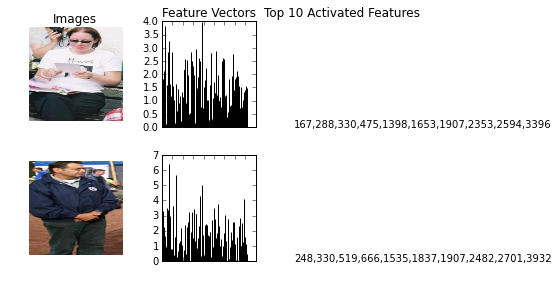

In [102]:
from PIL import Image 

image_files_path = '../image_dump/cropped/'
def image_file_for_data_file(data_file):
    return image_files_path + data_file.split('.')[0] + '.jpg'

right_person = right_dataframe[right_dataframe["Label"] == 1]
person1 = right_person.iloc[4]["Image Index"]
person1_data = data[list(data_files).index(person1)]
person2 = right_person.iloc[20]["Image Index"]
person2_data = data[list(data_files).index(person2)]

def most_activated_features(data):
    return ','.join(map(str,sorted(list(np.argsort(data)[-10:]))))

def show_comparison_plot(object1, data1, object2, data2):
    fig = plt.figure()
    ax = fig.add_subplot(231)
    ax.axis('off')
    plt.title("Images")
    plt.imshow(Image.open(image_file_for_data_file(object1)))
    
    ax = fig.add_subplot(232)
    ax.set_xticklabels([])
    plt.bar(np.arange(importances.shape[0]), data1, width)
    plt.title("Feature Vectors")

    ax = fig.add_subplot(233)
    ax.axis('off')
    plt.title("Top 10 Activated Features")
    plt.text(0,0,most_activated_features(data1))
    
    ax = fig.add_subplot(234)
    ax.axis('off')
    plt.imshow(Image.open(image_file_for_data_file(object2)))
    
    ax = fig.add_subplot(235)
    ax.set_xticklabels([])
    plt.bar(np.arange(importances.shape[0]), data2, width)
    
    ax = fig.add_subplot(236)
    ax.axis('off')
    plt.text(0,0,most_activated_features(data2))

    plt.tight_layout()
    plt.show()
    
show_comparison_plot(person1, person1_data, person2, person2_data)

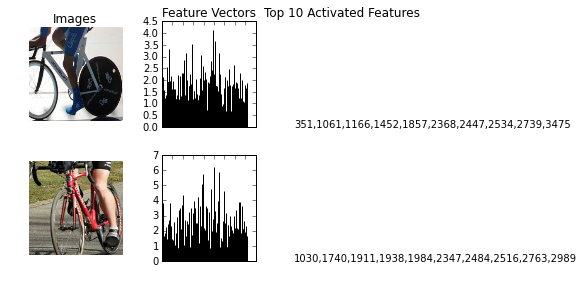

In [103]:
right_bicycle = right_dataframe[right_dataframe["Label"] == 2]
bicycle1 = right_bicycle.iloc[5]["Image Index"]
bicycle1_data = data[list(data_files).index(bicycle1)]
bicycle2 = right_bicycle.iloc[12]["Image Index"]
bicycle2_data = data[list(data_files).index(bicycle2)]

show_comparison_plot(bicycle1, bicycle1_data, bicycle2, bicycle2_data)

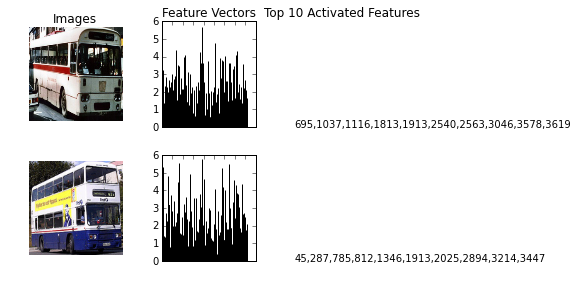

In [104]:
right_bus = right_dataframe[right_dataframe["Label"] == 3]
bus1 = right_bus.iloc[4]["Image Index"]
bus1_data = data[list(data_files).index(bus1)]
bus2 = right_bus.iloc[12]["Image Index"]
bus2_data = data[list(data_files).index(bus2)]

show_comparison_plot(bus1, bus1_data, bus2, bus2_data)

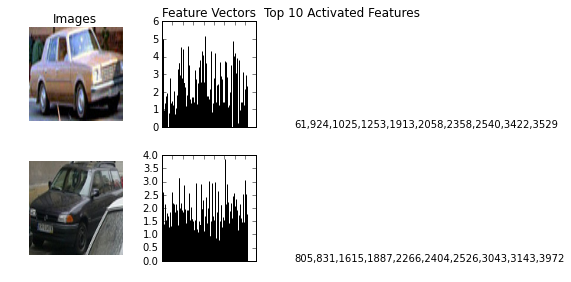

In [105]:
right_car = right_dataframe[right_dataframe["Label"] == 4]
car1 = right_car.iloc[2]["Image Index"]
car1_data = data[list(data_files).index(car1)]
car2 = right_car.iloc[12]["Image Index"]
car2_data = data[list(data_files).index(car2)]

show_comparison_plot(car1, car1_data, car2, car2_data)

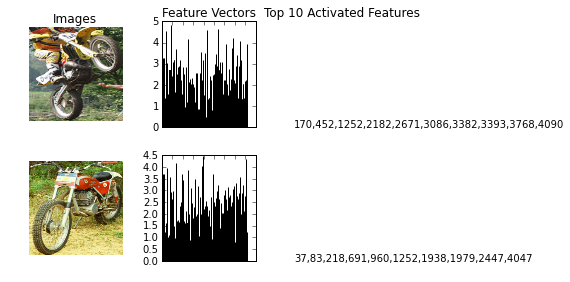

In [106]:
right_motorbike = right_dataframe[right_dataframe["Label"] == 5]
motorbike1 = right_motorbike.iloc[1]["Image Index"]
motorbike1_data = data[list(data_files).index(motorbike1)]
motorbike2 = right_motorbike.iloc[13]["Image Index"]
motorbike2_data = data[list(data_files).index(motorbike2)]

show_comparison_plot(motorbike1, motorbike1_data, motorbike2, motorbike2_data)